# ========================
# Chapter 0. Imports
# ========================

In [1]:
import numpy as np

from astropy import units as u
from astropy import time as astrotime
from astropy.constants import R_earth

from datetime import datetime

import cysgp4

from pycraf import conversions as cnv
from pycraf.geometry import true_angular_distance
from pycraf.antenna import ras_pattern

from scepter import scenario
from scepter import tleforger
from scepter.antenna import s_1528_rec1_2_pattern
from scepter.earthgrid import generate_hexgrid_full, calculate_footprint_size, trunc_hexgrid_to_impactful
from scepter import satsim
from scepter.gpu_accel import true_angular_distance_auto
from scepter.skynet import pointgen_S_1586_1


from tqdm.auto import tqdm

c:\Users\boris.sorokin\AppData\Local\miniforge3\envs\scepter-dev\lib\site-packages\cysgp4\helpers.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


# ========================
# Chapter 1. Calculation
# ========================

In [2]:
# This is rough estimate of memory pressure in MB
_TIMESTAMP_MEM=8*1024
# Indicate how much memory could be allocated for the script
_AVAILABLE_MEM=8*1024
_BULK_TIMESTAMPS=int(np.min(np.floor(_AVAILABLE_MEM/_TIMESTAMP_MEM)))
print(f"Maximum number of simultaneous timesteps is {_BULK_TIMESTAMPS}")

_STORAGE_FILENAME="simulation_results.h5"


FREQUENCY = 10700 * u.MHz
wavelength = FREQUENCY.to(u.m, equivalencies=u.spectral())

Maximum number of simultaneous timesteps is 1


In [3]:
scenario.init_simulation_results(_STORAGE_FILENAME)

In [4]:
start_time = astrotime.Time(datetime(2025, 1, 1, 0, 0, 0))
end_time =  astrotime.Time(datetime(2025, 1, 1, 0, 15, 0))
timestep = 1 # steps in seconds
time_batches=scenario.generate_simulation_batches(start_time, end_time, timestep, _BULK_TIMESTAMPS)

n_times = len(time_batches['times'][0])  # total frames per batch
n_batches = len(time_batches['times'])  # total frames per batch
print(f'Simulation will include approximately {n_times} time stamps for each of {n_batches} batches')

Simulation will include approximately 1 time stamps for each of 901 batches


In [5]:
tleforger.reset_tle_counter()
# 1.16 system C
belt_names = []
belt_sats = []
altitudes = []
max_deviation_angles = []
tle_list = []
min_elevations = []
max_betas = []
belt_name='SystemC_Belt_1'
num_sats_per_plane = 40
plane_count = 18
altitude = 1200 * u.km
eccentricity = 0.0
inclination_deg = 87.9 * u.deg
argp_deg = 0.0 * u.deg
RAAN_min = 0 * u.deg
RAAN_max = 180 * u.deg
max_deviation_angle = np.arcsin(R_earth / (R_earth + altitude)).to(u.deg)
min_elevation = 30 * u.deg
max_beta = np.arcsin((R_earth*np.sin(90*u.deg+min_elevation))/(R_earth+altitude)).to(u.deg)
Nco=1
Nbeam=None
mode='CELL'


System_C_tle_list = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, 
                                            plane_count=plane_count, RAAN_min=RAAN_min, 
                                            RAAN_max=RAAN_max, altitude=altitude, eccentricity=eccentricity, inclination_deg=inclination_deg, 
                                            argp_deg=argp_deg, adjacent_plane_offset=False)



belt_names.append(belt_name)
belt_sats.append(len(System_C_tle_list))
altitudes.append(altitude)
max_deviation_angles.append(max_deviation_angle)
tle_list.extend(System_C_tle_list)
min_elevations.append(min_elevation)
max_betas.append(max_beta)

belt_sats = np.array(belt_sats)
altitudes = np.array(altitudes, dtype=object)
max_deviation_angles = np.array(max_deviation_angles, dtype=object)
tle_list = np.array(tle_list, dtype=object)
min_elevations = np.array(min_elevations, dtype=object)
max_betas = np.array(max_betas, dtype=object)

format_func = np.vectorize(lambda x: f"{x:.2f}")
n_sats = len(tle_list)
print(f'Total number of satellites: {n_sats}')
print(f'Defined belts are {belt_names} with number of sats per belt {belt_sats} at altitudes {format_func(altitudes)}.\n'+
    f'Their absolute max offset β angles are {format_func(max_deviation_angles)}\n'+
    f'With min elevation {format_func(min_elevations)} their max offset β angles are {format_func(max_betas)}')

Total number of satellites: 720
Defined belts are ['SystemC_Belt_1'] with number of sats per belt [720] at altitudes ['1200.00 km'].
Their absolute max offset β angles are ['57.31 deg']
With min elevation ['30.00 deg'] their max offset β angles are ['46.79 deg']


In [6]:
latitude = -30.712777 * u.deg
longitude = 21.443611 * u.deg
elevation = 1052.0 * u.m
SKAO=cysgp4.PyObserver(longitude.value,latitude.value,elevation.to(u.km).value)

SKAO_ant_diam = 15 * u.m
observer_list=[SKAO]
print(f'RAS stations defined as {observer_list}')
highest_altitude = np.max(altitudes)
slant_distance_max = (np.sqrt((R_earth + highest_altitude)**2 - (R_earth)**2)).to(u.km)
max_deviation_angle = np.arcsin(R_earth / (R_earth + highest_altitude)).to(u.deg)
print(f'Highest altitude is {highest_altitude:.2f}\nMaximum slant path possible {slant_distance_max:.2f} at {max_deviation_angle:.2f} offset β angle')

RAS stations defined as [<PyObserver: 21.4436d, -30.7128d, 1.0520km>]
Highest altitude is 1200.00 km
Maximum slant path possible 4092.36 km at 57.31 deg offset β angle


In [7]:
# altitude_ex = highest_altitude
# off_nadir_ex = 0 * u.deg
# pattern_kwargs_ex = {
#     'D': 4.0 * u.m,
#     'wavelength': wavelength,
#     'LN': -20 * cnv.dB
# }
# footprint_low = calculate_footprint_size(
#     antenna_gain_func=s_1528_rec1_2_pattern,
#     altitude=altitude_ex,
#     off_nadir_angle=off_nadir_ex,
#     earth_model='spherical',
#     **pattern_kwargs_ex
# )
# print(f"Footprint size is {footprint_low.to(u.km)}")
# point_spacing = footprint_low
if mode == 'CELL':
    point_spacing = 2000*u.km
    grid_lons, grid_lats, _ = generate_hexgrid_full(point_spacing)
    separation=true_angular_distance(longitude, latitude, grid_lons, grid_lats)
    close_cell_ID=np.argmin(separation)
    lon_shift=grid_lons[close_cell_ID]-longitude
    lat_shift=grid_lats[close_cell_ID]-latitude
    print(f"Hexgrid is shifted by {lon_shift:.2f} in longitude and {lat_shift:.2f} in latitude. Closest cell ID is {close_cell_ID}")
    grid_lons=grid_lons-lon_shift
    grid_lats=np.clip((grid_lats-lat_shift).value, -90, 90)*u.deg
    mask = trunc_hexgrid_to_impactful(grid_lons,grid_lats,highest_altitude,min_elevation,latitude,longitude,elevation)
    active_grid_lons=grid_lons[mask]
    active_grid_lats=grid_lats[mask]
    ACTIVE_CELL_LIST=[]
    for i in range (np.size(active_grid_lons)):
        ACTIVE_CELL=cysgp4.PyObserver(active_grid_lons[i].value,active_grid_lats[i].value,0)    
        ACTIVE_CELL_LIST.append(ACTIVE_CELL)

    print(f'Total number of cells is {np.size(grid_lons)}')
    print(f'Total number of impactful cells is {np.size(active_grid_lons)}')
    separation=true_angular_distance(longitude, latitude, active_grid_lons, active_grid_lats)
    close_cell_ID=np.argmin(separation)
    print(f'RAS station located at Cell ID {close_cell_ID}')

    if(len(observer_list)==1):
        observer_list.extend(ACTIVE_CELL_LIST)
    else:
        observer_list_new=[SKAO]
        observer_list_new.extend(ACTIVE_CELL_LIST)
        observer_list=observer_list_new
else:
    min_offset = 5 * u.deg 
    DISTR_BOTH_UNI = False
    Nbeam = 1 if Nbeam is None else Nbeam

Hexgrid is shifted by -2.98 deg in longitude and 0.31 deg in latitude. Closest cell ID is 130
Total number of cells is 162
Total number of impactful cells is 26
RAS station located at Cell ID 16


In [8]:
observer_list=np.array(observer_list)
#Reshaping the inputs
observers_new=observer_list[np.newaxis, :, np.newaxis]
tles_new=tle_list[np.newaxis, np.newaxis, :]

In [9]:
niter=10
rng = np.random.default_rng(seed=42)

In [10]:
from importlib import reload
reload(satsim)
reload(scenario)
scenario.init_simulation_results(_STORAGE_FILENAME)
base_start_time = astrotime.Time(datetime(2025, 1, 1, 0, 0, 0))
base_end_time =  astrotime.Time(datetime(2025, 1, 1, 0, 3, 0))
timestep = 1 # steps in seconds
for ii in (pbarExt := tqdm(range(niter), desc='Iterations')):
    jitter_sec = rng.uniform(0, 3600)
    time_shift      = astrotime.TimeDelta(jitter_sec, format="sec")
    start_time = base_start_time + time_shift
    end_time   = base_end_time   + time_shift
    
    time_batches=scenario.generate_simulation_batches(start_time, end_time, timestep, 3)
    n_batches = len(time_batches['times'])
    
    for i in (pbar := tqdm(range(n_batches), desc='Processing time slices:', leave=False)):
        # Prepare time slice    
        local_times = time_batches['times'][i]
        n_local_times = len(local_times)
        mjds_new=local_times.mjd[:, np.newaxis, np.newaxis]
        # Simualte satellite movement
        pbar.set_description("Processing satellite positions")
        result = cysgp4.propagate_many(mjds_new, 
                                tles_new, 
                                observers_new, 
                                do_eci_pos=False, 
                                do_eci_vel=False, 
                                do_geo=False, 
                                do_topo=True,
                                do_obs_pos=False,
                                do_sat_azel=True,
                                do_sat_rotmat=False,
                                sat_frame='xyz')
        sat_topo=result['topo'] # anges to satellites in local observers' frames
        sat_azel=result['sat_azel'] # anges to observer in local satellites' frames
        # Shape is (times, observers, satellites,...)

        # Generate sky cell pointings
        tel_az, tel_el, _ = pointgen_S_1586_1(n_local_times)

        if mode == 'CELL':
            # -------------------- BEAM SELECTION ----------------
            pbar.set_description("Processing beams")
            sat_cell_links = satsim.compute_sat_cell_links_auto(sat_topo, min_elevation, Nco, cell_observer_offset=1, 
                                                                Nbeam=Nbeam, BA_mode=False)
            sat_cell_links_BA = satsim.compute_sat_cell_links_auto(sat_topo, min_elevation, Nco, cell_observer_offset=1, 
                                                                   Nbeam=Nbeam, BA_mode=True, BA_switchoff_angle=1*u.deg,
                                                                BA_redirection_angle=5*u.deg,
                                                                BA_redirection_angle_separation=10*u.deg,
                                                                BA_redirection_avoid_cells=close_cell_ID,
                                                                tel_az=tel_az, tel_el=tel_el,
                                                                sat_azel=sat_azel)
            no_link_mask = (sat_cell_links == -1)
            no_link_mask_BA = (sat_cell_links_BA == -1)
            
            # -------------------- INITIAL ANGLE CALCULATION ----------------
            pbar.set_description("Processing angles")
            # Calculate satellite antennas off-axis angles. This block uses satellites as reference points.
            # RAS station azimuth/elevation in satellites' reference frames (shape: (n_time, n_satellites))
            ras_az = sat_azel[:,0,:,0]
            ras_el = sat_azel[:,0,:,1]

            # Earthgrid cells azimuth/elevation in satellites' reference frames (shape: (n_time, n_cell, n_satellites))
            sat_antenna_az = sat_azel[:,-np.size(active_grid_lons):,:,0]
            sat_antenna_el = sat_azel[:,-np.size(active_grid_lons):,:,1]

            sat_antenna_az_BA = sat_azel[:,np.newaxis,-np.size(active_grid_lons):,:,0] # <- extra dimension for skycells
            sat_antenna_el_BA = sat_azel[:,np.newaxis,-np.size(active_grid_lons):,:,1]  

            
            
            # -------------------- SUBSEQUENT ANGLE CALCULATION ----------------
            # For cells, extract the satellite antenna azimuth and elevation corresponding to the linked satellites.
            # The outputs below will have shape (n_time, n_cells, Nco).
            selected_sat_antenna_az = np.take_along_axis(sat_antenna_az, sat_cell_links, axis=-1)
            selected_sat_antenna_el = np.take_along_axis(sat_antenna_el, sat_cell_links, axis=-1)
            
            selected_sat_antenna_az_BA = np.take_along_axis(sat_antenna_az_BA, sat_cell_links_BA, axis=-1)
            selected_sat_antenna_el_BA = np.take_along_axis(sat_antenna_el_BA, sat_cell_links_BA, axis=-1)

            # Expand ras_az and ras_el to (n_time, 1, n_satellites) to broadcast over cells.        
            selected_ras_az = np.take_along_axis(ras_az[:, np.newaxis, :], sat_cell_links, axis=-1)
            selected_ras_el = np.take_along_axis(ras_el[:, np.newaxis, :], sat_cell_links, axis=-1)

            # Expand ras_az and ras_el to (n_time, 1, 1, n_satellites) to broadcast over sky and Earth cells.   
            selected_ras_az_BA = np.take_along_axis(ras_az[:, np.newaxis, np.newaxis, :], sat_cell_links_BA, axis=-1)
            selected_ras_el_BA = np.take_along_axis(ras_el[:, np.newaxis, np.newaxis, :], sat_cell_links_BA, axis=-1)

            offset_deg_gtx_selected = true_angular_distance_auto(selected_ras_az * u.deg, 
                                                                (90 - selected_ras_el) * u.deg,
                                                                selected_sat_antenna_az * u.deg, 
                                                                (90 - selected_sat_antenna_el) * u.deg
                                                                )
            
            offset_deg_gtx_selected_BA = true_angular_distance_auto(selected_ras_az_BA * u.deg, 
                                                                (90 - selected_ras_el_BA) * u.deg,
                                                                selected_sat_antenna_az_BA * u.deg, 
                                                                (90 - selected_sat_antenna_el_BA) * u.deg
                                                                )

            # Calculate RAS antenna off-axis angles for different telescope pontings and satellite positions. The shape is (timestamp, sky_cell, satellite). 
            # Do not confuse sky cells with satellite coverage cells provided by earthgrid module. This block uses RAS station as a reference point.
            # satellite azimuth/elevation in RAS station reference frame from sat_topo (shape: (n_time, n_satellites))
            sat_position_az = sat_topo[:, 0, :, 0]
            sat_position_el = sat_topo[:, 0, :, 1]

            selected_sat_position_az = np.take_along_axis(sat_position_az[:, np.newaxis, :], sat_cell_links, axis=-1)
            selected_sat_position_el = np.take_along_axis(sat_position_el[:, np.newaxis, :], sat_cell_links, axis=-1)

            selected_sat_position_az_BA = np.take_along_axis(sat_position_az[:, np.newaxis, np.newaxis, :], sat_cell_links_BA, axis=-1)
            selected_sat_position_el_BA = np.take_along_axis(sat_position_el[:, np.newaxis, np.newaxis, :], sat_cell_links_BA, axis=-1)

            offset_deg_grx = true_angular_distance_auto(tel_az[:, :, np.newaxis, np.newaxis]*u.deg, tel_el[:, :, np.newaxis, np.newaxis]*u.deg, 
                                            selected_sat_position_az[:, np.newaxis, :, :]*u.deg, selected_sat_position_el[:, np.newaxis, :, :]*u.deg)
            
            offset_deg_grx_BA = true_angular_distance_auto(tel_az[:, :, np.newaxis, np.newaxis]*u.deg, tel_el[:, :, np.newaxis, np.newaxis]*u.deg, 
                                            selected_sat_position_az_BA*u.deg, selected_sat_position_el_BA*u.deg)
        else:
            BA_switchoff_angle=1*u.deg
            BA_redirection_angle=5*u.deg
            BA_redirection_angle_separation= 10 * u.deg
            
            # ------------------------- Rx gains calculation
            pbar.set_description("Processing Rx gain")
            sat_position_az = sat_topo[:, 0, :, 0]
            sat_position_el = sat_topo[:, 0, :, 1]

            offset_deg_grx = true_angular_distance_auto(tel_az[:, :, np.newaxis] * u.deg, tel_el[:, :, np.newaxis] * u.deg,
                                                        sat_position_az[:,np.newaxis,:] * u.deg, sat_position_el[:,np.newaxis,:] * u.deg)
            offset_deg_grx_BA = true_angular_distance_auto(tel_az[:, :, np.newaxis] * u.deg, tel_el[:, :, np.newaxis] * u.deg,
                                                        sat_position_az[:,np.newaxis,:] * u.deg, sat_position_el[:,np.newaxis,:] * u.deg)

            # ------------------------- Tx gains calculation
            # Nco beam selection mechanism            
            pbar.set_description("Processing eligible satellites")
            # Dimensions: use the telescope sky grid
            T, Sky, S = offset_deg_grx.shape  # (time, skycells, satellites)

            # Satellite elevation above RAS horizon (T, S) → broadcast to (T, Sky, S)
            visible = (sat_topo[:, 0, :, 1] > min_elevation.to_value(u.deg))  # (T, S)
            serve_matrix    = np.broadcast_to(visible[:, None, :], (T, Sky, S))
            serve_matrix_BA = serve_matrix & (offset_deg_grx > BA_switchoff_angle)

            Sky_BA = Sky

            
            B = Nbeam
            serve_matrix_beam = np.repeat(serve_matrix[..., None], B, axis=-1)
            serve_matrix_beam_BA = np.repeat(serve_matrix_BA[..., None], B, axis=-1)

            pbar.set_description("Selection start")
            rand_vals = np.random.rand(T, Sky, S, B)
            rand_vals_BA = np.random.rand(T, Sky_BA, S, B)
            rand_vals[~serve_matrix] = -np.inf # not eligible to serve area satellites should be ignored
            rand_vals_BA[~serve_matrix_BA] = -np.inf # not eligible to serve area satellites should be ignored
            # Flatten (S,B) → C = S⋅B for the “top-N” ranking
            C = S * B
            rand_flat = rand_vals.reshape(T, Sky, C)
            rand_flat_BA = rand_vals_BA.reshape(T, Sky_BA, C)

            sorted_idx = np.argsort(-rand_flat, axis=-1)    # descending
            sorted_idx_BA = np.argsort(-rand_flat_BA, axis=-1)    # descending

            topN_flat  = sorted_idx[..., :Nco]              # (T,O,Nco)
            topN_flat_BA  = sorted_idx_BA[..., :Nco]              # (T,O,Nco)

            selected   = np.take_along_axis(rand_flat, topN_flat, axis=-1)
            valid      = selected > -np.inf                 # may be < Nco true’s

            selected_BA   = np.take_along_axis(rand_flat_BA, topN_flat_BA, axis=-1)
            valid_BA      = selected_BA > -np.inf                 # may be < Nco true’s

            # Map flat indices back to (sat, beam)
            sat_idx, beam_idx = np.unravel_index(topN_flat, (S, B))  # each (T,O,Nco)
            sat_idx_BA, beam_idx_BA = np.unravel_index(topN_flat_BA, (S, B))  # each (T,O,Nco)

            # Activation mask  (T,O,S,B)
            activation_matrix = np.zeros((T, Sky, S, B), dtype=bool)
            t_idx, o_idx = np.indices((T, Sky))                           
            activation_matrix[t_idx[..., np.newaxis], o_idx[..., np.newaxis],
                            sat_idx, beam_idx] = valid
            
            activation_matrix_BA = np.zeros((T, Sky_BA, S, B), dtype=bool)
            t_idx_BA, o_idx_BA = np.indices((T, Sky_BA))                           
            activation_matrix_BA[t_idx_BA[..., np.newaxis], o_idx_BA[..., np.newaxis],
                            sat_idx_BA, beam_idx_BA] = valid_BA
            
            # Direction to RAS station in satellite's own frame
            ras_az = np.broadcast_to(sat_azel[:, 0, :, 0][:, None, :, None], (T, Sky, S, B)) * u.deg
            ras_el = np.broadcast_to(sat_azel[:, 0, :, 1][:, None, :, None], (T, Sky, S, B)) * u.deg

            ras_az_BA = np.broadcast_to(sat_azel[:, 0, :, 0][:, None, :, None], (T, Sky_BA, S, B)) * u.deg
            ras_el_BA = np.broadcast_to(sat_azel[:, 0, :, 1][:, None, :, None], (T, Sky_BA, S, B)) * u.deg

            # random derp-rections for all beams
            random_az = rng.uniform(0, 360, size=(T, Sky, S, B)) * u.deg
            if DISTR_BOTH_UNI:
                random_el = rng.uniform(0, max_beta, size=(T, Sky, S, B)) * u.deg
            else:
                temp = rng.random((T, Sky, S, B))
                random_el = (np.rad2deg(
                            np.arccos(1 - temp * (1 - np.cos(np.deg2rad(max_beta))))
                            ))
                
            random_az_BA = rng.uniform(0, 360, size=(T, Sky_BA, S, B)) * u.deg
            if DISTR_BOTH_UNI:
                random_el_BA = rng.uniform(0, max_beta, size=(T, Sky_BA, S, B)) * u.deg
            else:
                temp = rng.random((T, Sky_BA, S, B))
                random_el_BA = (np.rad2deg(
                            np.arccos(1 - temp * (1 - np.cos(np.deg2rad(max_beta))))
                            ))
            
            pbar.set_description("Selection refinement")
            #  beams not serving the RAS cell are cast away
            mask = (~activation_matrix) & (
                    true_angular_distance_auto(ras_az,
                                                90 * u.deg - ras_el,
                                                random_az,
                                                90 * u.deg - random_el) < min_offset)
            
            while np.any(mask):
                # redraft only the offending beams
                random_az[mask] = rng.uniform(0, 360, size=mask.sum()) * u.deg
                if DISTR_BOTH_UNI:
                    random_el[mask] = rng.uniform(0, max_beta, size=mask.sum()) * u.deg
                else:
                    temp = rng.random(mask.sum())
                    random_el[mask] = (np.rad2deg(
                                        np.arccos(1 - temp * (1 - np.cos(np.deg2rad(max_beta))))
                                    ))
                mask = (~activation_matrix) & (
                    true_angular_distance_auto(ras_az,
                                                90*u.deg - ras_el,
                                                random_az,
                                                90*u.deg - random_el) < min_offset)
            redir_band = (offset_deg_grx > BA_switchoff_angle) & (offset_deg_grx < BA_redirection_angle)
            redir_band_beam = np.repeat(redir_band[..., np.newaxis], B, axis=-1)
            limit_BA = np.where(redir_band_beam, BA_redirection_angle_separation, min_offset)    
            mask_BA = (~activation_matrix_BA) & (
                    true_angular_distance_auto(ras_az_BA,
                                                90 * u.deg - ras_el_BA,
                                                random_az_BA,
                                                90 * u.deg - random_el_BA) < limit_BA)
            
            while np.any(mask_BA):
                # redraft only the offending beams
                random_az_BA[mask_BA] = rng.uniform(0, 360, size=mask_BA.sum()) * u.deg
                if DISTR_BOTH_UNI:
                    random_el_BA[mask_BA] = rng.uniform(0, max_beta, size=mask_BA.sum()) * u.deg
                else:
                    temp_BA = rng.random(mask_BA.sum())
                    random_el_BA[mask_BA] = (np.rad2deg(
                                        np.arccos(1 - temp_BA * (1 - np.cos(np.deg2rad(max_beta))))
                                    ))
                mask_BA = (~activation_matrix_BA) & (
                    true_angular_distance_auto(ras_az_BA,
                                                90*u.deg - ras_el_BA,
                                                random_az_BA,
                                                90*u.deg - random_el_BA) < limit_BA)
            pbar.set_description("Gtx calculation")    
            sat_antenna_az = np.where(activation_matrix, ras_az, random_az)
            sat_antenna_el = np.where(activation_matrix, ras_el, random_el)

            sat_antenna_az_BA = np.where(activation_matrix_BA, ras_az_BA, random_az_BA)
            sat_antenna_el_BA = np.where(activation_matrix_BA, ras_el_BA, random_el_BA)

            offset_deg_gtx = true_angular_distance_auto(ras_az,
                                                        90*u.deg - ras_el,
                                                        sat_antenna_az,
                                                        90*u.deg - sat_antenna_el)  

            offset_deg_gtx_BA = true_angular_distance_auto(ras_az_BA,
                                                        90*u.deg - ras_el_BA,
                                                        sat_antenna_az_BA,
                                                        90*u.deg - sat_antenna_el_BA)


     

        # -------------------- POWER CALCULATION ----------------
        pbar.set_description("Processing power")
        if mode == 'CELL':                
            # gtx and distances_earthgrid_cells_trunc shapes will be (n_time, n_cells, Nco)
            distances_earthgrid_cells_trunc = np.take_along_axis(sat_topo[:, 1:, :, 2], sat_cell_links, axis=-1)*u.km
            distances_earthgrid_cells_trunc_BA = np.take_along_axis(sat_topo[:, np.newaxis, 1:, :, 2], sat_cell_links_BA, axis=-1)*u.km
            Gtx, Gm, _ = s_1528_rec1_2_pattern(offset_deg_gtx_selected)
            Gtx_BA, Gm_BA, _ = s_1528_rec1_2_pattern(offset_deg_gtx_selected_BA)


            powerflux = (-82.5) * cnv.dB_W_m2
            Ptx = cnv.ptx_from_powerflux(powerflux, distances_earthgrid_cells_trunc, Gm)[:,np.newaxis,:,:]
            
            Ptx_BA = cnv.ptx_from_powerflux(powerflux, distances_earthgrid_cells_trunc_BA, Gm_BA)
            Ptx = np.repeat(Ptx, repeats=Ptx_BA.shape[1], axis=1)
            # Ptx = 16*cnv.dB_W
            Gtx = Gtx[:,np.newaxis,:,:]
            Grx = ras_pattern(offset_deg_grx, SKAO_ant_diam, wavelength)
            Grx_BA = ras_pattern(offset_deg_grx_BA, SKAO_ant_diam, wavelength)
            distances_2RAS = sat_topo[:, 0, :, 2] * u.km
            distances_2RAS_selected = np.take_along_axis(distances_2RAS[:, np.newaxis, :], sat_cell_links, axis=-1)[:,np.newaxis,:,:]
            distances_2RAS_selected_BA = np.take_along_axis(distances_2RAS[:, np.newaxis, np.newaxis, :], sat_cell_links_BA, axis=-1)
            satellite_elevation_from_RAS = np.take_along_axis(sat_topo[:,0,:,1][:, np.newaxis, :], sat_cell_links, axis=-1)
            satellite_elevation_from_RAS_BA = np.take_along_axis(sat_topo[:,0,:,1][:, np.newaxis, np.newaxis, :], sat_cell_links_BA, axis=-1)

            # target shape is (timestamp,sky_cell,earth_grid_cell, Nco)
            Prx = cnv.prx_from_ptx(Ptx, Gtx, Grx, distances_2RAS_selected, FREQUENCY)
            Prx_BA = cnv.prx_from_ptx(Ptx_BA, Gtx_BA, Grx_BA, distances_2RAS_selected_BA, FREQUENCY)

            elev_mask = (satellite_elevation_from_RAS < 0)
            combined_mask = no_link_mask | elev_mask
            mask_full = np.broadcast_to(combined_mask[:,np.newaxis,:,:], Prx.shape)
            Prx[mask_full]= np.nan * u.W
            Ptx[mask_full]= np.nan * u.W
            total_Prx=np.nansum(Prx, axis=(-2,-1))

            elev_mask_BA = (satellite_elevation_from_RAS_BA < 0)
            combined_mask_BA = no_link_mask_BA | elev_mask_BA
            mask_full_BA = np.broadcast_to(combined_mask_BA, Prx_BA.shape)
            Prx_BA[mask_full_BA]= np.nan * u.W
            Ptx_BA[mask_full_BA]= np.nan * u.W
            total_Prx_BA=np.nansum(Prx_BA, axis=(-2,-1))
            
            powerflux_2RAS = cnv.powerflux_from_ptx(Ptx,distances_2RAS_selected,Gtx) # check redundancy and correctness
            powerflux_2RAS_BA = cnv.powerflux_from_ptx(Ptx_BA,distances_2RAS_selected_BA,Gtx_BA)

            epfd_0_per_source=(powerflux_2RAS.to(cnv.dB_W_m2)+Grx).to(u.W/u.m**2)

            epfd_0_per_source_BA=(powerflux_2RAS_BA.to(cnv.dB_W_m2)+Grx_BA).to(u.W/u.m**2)
            
            epfd_0=np.nansum(epfd_0_per_source, axis=(-2,-1))
            epfd_0_BA=np.nansum(epfd_0_per_source_BA, axis=(-2,-1))
                

            times_array = local_times.mjd
            satellite_elevation_from_RAS[no_link_mask]=-1001
            satellite_elevation_from_RAS_BA[no_link_mask_BA]=-1001
            pbar.set_description("Storing results")
            if i == 0:
                append_axis=0
            else:
                append_axis=1
            
            scenario.store_iter_batch(
                _STORAGE_FILENAME,
                iteration=ii,
                times=times_array,
                Prx=Prx,
                Prx_BA=Prx_BA,
                total_Prx=total_Prx,
                total_Prx_BA=total_Prx_BA,
                powerflux_2RAS=powerflux_2RAS,
                powerflux_2RAS_BA=powerflux_2RAS_BA,
                epfd_0=epfd_0,
                epfd_0_BA=epfd_0_BA,
            )
            if i == n_batches-1:
                pbar.set_description("Finished")
        else:
            # -------------------- POWER CALCULATION ----------------
            pbar.set_description("Processing power")

            # TX patterns
            Gtx, Gm, _     = s_1528_rec1_2_pattern(offset_deg_gtx)          # (T, Sky, S, B)
            Gtx_BA, Gm_BA, _ = s_1528_rec1_2_pattern(offset_deg_gtx_BA)     # (T, Sky_BA, S, B)

            powerflux = (-82.5) * cnv.dB_W_m2

            # ▶ Build full distance arrays matching the beam grids
            distances_2RAS = sat_topo[:, 0, :, 2] * u.km                     # (T, S)
            dist_exp       = distances_2RAS[:, None, :, None]                # (T, 1, S, 1)
            dist_full      = np.broadcast_to(dist_exp, Gtx.shape) * dist_exp.unit             # (T, Sky,   S, B)
            dist_full_BA   = np.broadcast_to(dist_exp, Gtx_BA.shape) * dist_exp.unit         # (T, Sky_BA, S, B)

            # ▶ Compute Ptx with fully-expanded distance shapes so Ptx matches (T,Sky,S,B)
            Ptx    = cnv.ptx_from_powerflux(powerflux, dist_full,    Gm)     # (T, Sky,   S, B)
            Ptx_BA = cnv.ptx_from_powerflux(powerflux, dist_full_BA, Gm_BA)  # (T, Sky_BA, S, B)

            # RX patterns
            Grx    = ras_pattern(offset_deg_grx,    SKAO_ant_diam, wavelength)    # (T, Sky,   S)
            Grx_BA = ras_pattern(offset_deg_grx_BA, SKAO_ant_diam, wavelength)    # (T, Sky_BA, S)

            # Received power
            Prx    = cnv.prx_from_ptx(Ptx,    Gtx,    Grx[..., None],    dist_full,    FREQUENCY)  # (T,Sky,S,B)
            Prx_BA = cnv.prx_from_ptx(Ptx_BA, Gtx_BA, Grx_BA[..., None], dist_full_BA, FREQUENCY)  # (T,Sky,S,B)

            # ▶ Build exact-shape masks before assigning NaNs
            elev_mask_full    = np.broadcast_to((sat_position_el < 0)[:, None, :, None], Prx.shape)
            full_mask         = (~activation_matrix) | elev_mask_full
            Prx[full_mask]    = np.nan * u.W
            Ptx[full_mask]    = np.nan * u.W

            elev_mask_BA_full = np.broadcast_to((sat_position_el < 0)[:, None, :, None], Prx_BA.shape)
            full_mask_BA      = (~activation_matrix_BA) | elev_mask_BA_full
            Prx_BA[full_mask_BA] = np.nan * u.W
            Ptx_BA[full_mask_BA] = np.nan * u.W

            # Aggregates
            total_Prx    = np.nansum(Prx,    axis=(-2, -1))  # (T, Sky)
            total_Prx_BA = np.nansum(Prx_BA, axis=(-2, -1))  # (T, Sky_BA)

            # Per-source PFD & EPFD
            powerflux_2RAS    = cnv.powerflux_from_ptx(Ptx,    dist_full,    Gtx)
            powerflux_2RAS_BA = cnv.powerflux_from_ptx(Ptx_BA, dist_full_BA, Gtx_BA)

            epfd_0_per_source    = (powerflux_2RAS.to(cnv.dB_W_m2)    + Grx[...,    None]).to(u.W/u.m**2)
            epfd_0_per_source_BA = (powerflux_2RAS_BA.to(cnv.dB_W_m2) + Grx_BA[..., None]).to(u.W/u.m**2)

            epfd_0    = np.nansum(epfd_0_per_source,    axis=(-2, -1))  # (T, Sky)
            epfd_0_BA = np.nansum(epfd_0_per_source_BA, axis=(-2, -1))  # (T, Sky_BA)

            # Store
            times_array = local_times.mjd
            pbar.set_description("Storing results")
            append_axis = 0 if i == 0 else 1

            scenario.store_iter_batch(
                _STORAGE_FILENAME,
                iteration=ii,
                times=times_array,
                Prx=Prx,
                Prx_BA=Prx_BA,
                total_Prx=total_Prx,
                total_Prx_BA=total_Prx_BA,
                powerflux_2RAS=powerflux_2RAS,
                powerflux_2RAS_BA=powerflux_2RAS_BA,
                epfd_0=epfd_0,
                epfd_0_BA=epfd_0_BA,
            )

            if i == n_batches - 1:
                pbar.set_description("Finished")


Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Processing time slices::   0%|          | 0/61 [00:00<?, ?it/s]

Processing time slices::   0%|          | 0/61 [00:00<?, ?it/s]

Processing time slices::   0%|          | 0/61 [00:00<?, ?it/s]

Processing time slices::   0%|          | 0/61 [00:00<?, ?it/s]

Processing time slices::   0%|          | 0/61 [00:00<?, ?it/s]

Processing time slices::   0%|          | 0/61 [00:00<?, ?it/s]

Processing time slices::   0%|          | 0/61 [00:00<?, ?it/s]

Processing time slices::   0%|          | 0/61 [00:00<?, ?it/s]

Processing time slices::   0%|          | 0/61 [00:00<?, ?it/s]

Processing time slices::   0%|          | 0/61 [00:00<?, ?it/s]

In [15]:
sat_cell_links[0,0,0]

np.int32(701)

In [16]:
print(np.max(epfd_0.to(cnv.dB_W_m2)))
print(np.max(epfd_0_BA.to(cnv.dB_W_m2)))

-56.23988603053522 dB(W / m2)
-82.42019321447816 dB(W / m2)


In [17]:
from scepter import scenario, visualise
from pycraf import conversions as cnv

_STORAGE_FILENAME="simulation_results.h5"
results = scenario.read_iter_results(_STORAGE_FILENAME, stack=True)
# results = scenario.read_simulation_results(_STORAGE_FILENAME)
print(results.keys())
epfd_0_recovered=results["epfd_0"]
epfd_0_BA_recovered=results["epfd_0_BA"]

timestep,_ = scenario.analyse_time(results["times"][0,:])
print(f"Detected timestep is {timestep}")
timestep=timestep.value
window_size = int(2000 / timestep)
from scipy.ndimage import uniform_filter1d
epfd_0_recovered_smoothed = uniform_filter1d(epfd_0_recovered, size=window_size) * (epfd_0_recovered.unit)
epfd_0_BA_recovered_smoothed = uniform_filter1d(epfd_0_BA_recovered, size=window_size) * (epfd_0_BA_recovered.unit)

dict_keys(['Prx', 'Prx_BA', 'epfd_0', 'epfd_0_BA', 'powerflux_2RAS', 'powerflux_2RAS_BA', 'times', 'total_Prx', 'total_Prx_BA'])
Detected timestep is 0.9999999194405973 s


In [18]:
epfd_0_BA_recovered.shape

(10, 3, 2334)

In [19]:
epfd_0_recovered_smoothed.to(cnv.dB_W_m2).shape

(10, 3, 2334)

In [20]:
from __future__ import annotations

from typing import Any, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
import matplotlib.patheffects as pe

def _to_plain_array(data: Any) -> Tuple[np.ndarray, u.Unit | None]:
    """Convert ``data`` to a plain :class:`numpy.ndarray` and return its unit.

    Parameters
    ----------
    data : array-like or :class:`astropy.units.Quantity`
        Input values.  If ``data`` has a ``.unit`` attribute it will be
        stripped and returned.

    Returns
    -------
    array : :class:`numpy.ndarray`
        The numerical values of ``data`` with all dimensions preserved.
    unit : :class:`astropy.units.Unit` or ``None``
        The unit of ``data`` (``None`` if ``data`` was unitless).
    """
    if hasattr(data, "unit"):
        return np.asarray(data.value), data.unit
    return np.asarray(data), None

def prepare_cdf_ccdf_data(
    data: Any,
    *,
    num_points: int = 1000,
    request_2_percent: bool = False,
    request_5_percent: bool = False,
    log_mode = True
) -> Dict[str, Any]:
    """Prepare CDF/CCDF bounds for a power dataset.

    The input ``total_prx`` is expected to have the shape ``(time, skycell, 1)``
    as produced by the simulator.  The trailing ``1`` dimension is ignored.  For
    each skycell we flatten the time axis to obtain a one-dimensional array of
    samples.  A common x-axis grid is created and the empirical CDF for every
    skycell is interpolated onto this grid.  Finally, the minimum and maximum
    CDF/CCDF values across all skycells are computed.

    Optionally, the 2% (98th percentile) and/or 5% (95th percentile) value-
    ranges across skycells can be returned if ``request_2_percent`` and/or
    ``request_5_percent`` are True.

    Parameters
    ----------
    total_prx : array-like or :class:`astropy.units.Quantity`
        The simulated total received power with shape ``(time, skycell, 1)`` or
        ``(time, skycell)``.
    num_points : int, optional
        Number of points for the common x-axis grid.  A larger value gives
        smoother curves.  Default is ``1000``.
    request_2_percent : bool, optional
        If True, compute and return the 98th-percentile (“2% exceedance”) range.
    request_5_percent : bool, optional
        If True, compute and return the 95th-percentile (“5% exceedance”) range.

    Returns
    -------
    dict
        A dictionary containing:

        ``x_grid`` : array or :class:`~astropy.units.Quantity`
            The common x-axis grid.

        ``cdf_min`` / ``cdf_max`` : ndarray
            Minimum and maximum CDF values (in percent) on that grid.

        ``ccdf_min`` / ``ccdf_max`` : ndarray
            Minimum and maximum CCDF values (in percent) on that grid.

        ``ccdf_min_positive`` : float
            The smallest strictly-positive CCDF (in percent) across the grid.
            Useful for setting a nonzero lower bound on a log-y plot.

        ``quantile_range_2percent`` : tuple (min_value, max_value)
            Present only if ``request_2_percent=True``; the 98th-percentile
            range across skycells (units preserved).

        ``quantile_range_5percent`` : tuple (min_value, max_value)
            Present only if ``request_5_percent=True``; the 95th-percentile
            range across skycells (units preserved).
    """
    def _snap_to_grid(val, grid):
        # grid is already in dB at this point (if log_mode is True)
        idx = np.argmin(np.abs(grid - val))
        return grid[idx]
    # Convert to plain ndarray + track unit
    data_array, unit = _to_plain_array(data)
    data_array = data_array[:,:,0]
    if log_mode:
        data_array = np.power(10, (data_array / 10))

    if data_array.ndim != 2:
        raise ValueError(
            f"Expected 'data' with shape (time, skycell, 1) or (time, skycell), but got ndim {data_array.ndim}"
        )

    # Transpose so rows = skycells, columns = samples
    skycell_samples = data_array.T

    # Compute global min/max for x_grid
    all_vals = skycell_samples.flatten()
    vmin = np.min(all_vals)
    vmax = np.max(all_vals)
    x_grid = np.linspace(vmin, vmax, num_points)

    # Prepare envelopes
    cdf_min = np.full_like(x_grid, np.inf, dtype=float)
    cdf_max = np.full_like(x_grid, -np.inf, dtype=float)

    # Lists for optional quantiles
    cdf_stack = []
    quantiles_2 = []  # 98th percentile per skycell
    quantiles_5 = []  # 95th percentile per skycell

    for samples in skycell_samples:
        # Sort and build empirical CDF for this skycell
        sorted_samples = np.sort(samples)
        n = len(sorted_samples)
        cdf_vals = np.arange(1, n + 1) / n  # from 1/n ... 1.0

        # Interpolate onto common x_grid
        cdf_on_grid = np.interp(x_grid, sorted_samples, cdf_vals,
                                 left=0.0, right=1.0)

        # Update envelopes
        cdf_min = np.minimum(cdf_min, cdf_on_grid)
        cdf_max = np.maximum(cdf_max, cdf_on_grid)

        cdf_stack.append(cdf_on_grid)
        
        # 2% / 98th percentile
        if request_2_percent:
            quantiles_2.append(np.percentile(sorted_samples, 98))
        # 5% / 95th percentile
        if request_5_percent:
            quantiles_5.append(np.percentile(sorted_samples, 95))

    cdf_stack = np.vstack(cdf_stack)

    # Convert to *percent* before deriving CCDFs
    cdf_mean   = cdf_stack.mean(axis=0)   * 100.0
    cdf_median = np.median(cdf_stack, 0) * 100.0

    ccdf_mean   = 100.0 - cdf_mean
    ccdf_median = 100.0 - cdf_median

    # Convert envelope to percent
    cdf_min *= 100.0
    cdf_max *= 100.0
    ccdf_min = (1.0 - cdf_max / 100.0) * 100.0  # = 100*(1 - cdf_max/100)
    ccdf_max = (1.0 - cdf_min / 100.0) * 100.0

    # Find smallest strictly-positive ccdf_min entry (in percent)
    positive_ccdf = ccdf_min[ccdf_min > 0.0]
    if positive_ccdf.size > 0:
        ccdf_min_positive = float(np.min(positive_ccdf))
    else:
        # If none > 0, fall back to 100/n_max
        n_max = max(len(s) for s in skycell_samples)
        ccdf_min_positive = 100.0 / n_max

    if log_mode:
        x_grid = 10 * np.log10 (x_grid)

    # Build output dict
    out: Dict[str, Any] = {
        "x_grid": x_grid * unit if unit is not None else x_grid,
        "cdf_min": cdf_min,
        "cdf_max": cdf_max,
        "cdf_mean": cdf_mean,
        "cdf_median": cdf_median,
        "ccdf_min": ccdf_min,
        "ccdf_max": ccdf_max,
        "ccdf_mean": ccdf_mean,
        "ccdf_median": ccdf_median,
        "ccdf_min_positive": ccdf_min_positive,
    }

    # Attach optional quantile ranges (keeping units)
    if request_2_percent:
        quantiles_2 = np.asarray(quantiles_2)
        q2_min = quantiles_2.min()
        q2_max = quantiles_2.max()
        if log_mode:
            q2_min = 10 * np.log10 (q2_min)
            q2_max = 10 * np.log10 (q2_max)
            q2_min = _snap_to_grid(q2_min, x_grid)
            q2_max = _snap_to_grid(q2_max, x_grid)
        if unit is not None:
            q2_min *= unit
            q2_max *= unit
        out["quantile_range_2percent"] = (q2_min, q2_max)

    if request_5_percent:
        quantiles_5 = np.asarray(quantiles_5)
        q5_min = quantiles_5.min()
        q5_max = quantiles_5.max()
        if log_mode:
            q5_min = 10 * np.log10 (q5_min)
            q5_max = 10 * np.log10 (q5_max)
            q5_min = _snap_to_grid(q5_min, x_grid)
            q5_max = _snap_to_grid(q5_max, x_grid)
        if unit is not None:
            q5_min *= unit
            q5_max *= unit
        out["quantile_range_5percent"] = (q5_min, q5_max)

    return out

def plot_cdf_ccdf_bounds(
    data: Any,
    *,
    label: str = "epfd",
    plot_type: str = "ccdf",
    show_mean: bool = True, 
    show_median: bool = True, 
    show_two_percent: bool = True,
    show_five_percent: bool = False,
    y_min_percent: float | None = None,
    show: bool = True,
) -> plt.Figure:
    """Plot CDF or CCDF bounds computed by :func:`prepare_cdf_ccdf_data`.

    Expects that `data` is either the raw total_Prx or the dict returned by
    the updated `prepare_cdf_ccdf_data`, whose keys include:

      - "x_grid"               : array or Quantity
      - "cdf_min" / "cdf_max"  : ndarrays (in percent)
      - "ccdf_min" / "ccdf_max": ndarrays (in percent)
      - "ccdf_min_positive"    : float (smallest positive CCDF in percent)
      - optionally "quantile_range_2percent": (min, max) with units
      - optionally "quantile_range_5percent": (min, max) with units

    Parameters
    ----------
    data : array-like, Quantity, or dict
        Either raw total_Prx or the dict from prepare_cdf_ccdf_data().
    label : str, optional
        Base label for the x-axis (unit appended automatically if present).
    plot_type : {'cdf', 'ccdf'}, optional
        Choose whether to draw the CDF (in [%]) or the CCDF (in [%]).
        Default is 'ccdf'.
    show_two_percent : bool, optional
        If True and plot_type=='ccdf', draw a horizontal line at 2% and
        highlight the envelope region between the 98th-percentile bounds.
    show_five_percent : bool, optional
        If True and plot_type=='ccdf', draw a horizontal line at 5% and
        highlight the envelope region between the 95th-percentile bounds.
    y_min_percent : float or None, optional
        If provided and plot_type=='ccdf', force the lower y-limit to this
        percent value (instead of auto-computed). Useful to cut out CCDF below
        a chosen threshold.
    show : bool, optional
        If False, return the figure but close it to prevent Jupyter auto-render.

    Returns
    -------
    matplotlib.figure.Figure
        The created figure.  plt.show() is called only if show=True.
    """
    sns.set_theme(style="whitegrid", font_scale=1.1)

    needs_2 = show_two_percent
    needs_5 = show_five_percent

    if isinstance(data, dict) and "x_grid" in data:
        proc = data.copy()
        if needs_2 and "quantile_range_2percent" not in proc:
            raw = data.get("_raw_input", None)
            if raw is not None:
                proc = prepare_cdf_ccdf_data(raw,
                                             request_2_percent=True,
                                             request_5_percent=needs_5)
        if needs_5 and "quantile_range_5percent" not in proc:
            raw = data.get("_raw_input", None)
            if raw is not None:
                proc = prepare_cdf_ccdf_data(raw,
                                             request_2_percent=needs_2,
                                             request_5_percent=True)
    else:
        proc = prepare_cdf_ccdf_data(
            data,
            request_2_percent=needs_2,
            request_5_percent=needs_5
        )
        proc["_raw_input"] = data

    x = proc["x_grid"]
    cdf_min = proc["cdf_min"]
    cdf_max = proc["cdf_max"]
    ccdf_min = proc["ccdf_min"]
    ccdf_max = proc["ccdf_max"]
    ccdf_min_positive = proc["ccdf_min_positive"]

    # —— retrieve means / medians if present ————————————————
    cdf_mean   = proc.get("cdf_mean")
    cdf_median = proc.get("cdf_median")
    ccdf_mean   = proc.get("ccdf_mean")
    ccdf_median = proc.get("ccdf_median")

    if hasattr(x, "unit"):
        x_vals = x.value
        unit_str = f" ({x.unit})"
    else:
        x_vals = x
        unit_str = ""

    fig, ax = plt.subplots(figsize=(8, 6))

    if plot_type == "cdf":
        ax.fill_between(
            x_vals,
            cdf_min,
            cdf_max,
            color="skyblue",
            alpha=0.5,
            label="CDF envelope",
        )
        if show_mean and cdf_mean is not None:
            ax.plot(x_vals, cdf_mean,  lw=1.6,  color="navy",
                    label="Mean CDF")
        if show_median and cdf_median is not None:
            ax.plot(x_vals, cdf_median, lw=1.6,  color="darkgreen",
                    linestyle="--", label="Median CDF")
        ax.set_ylabel("Cumulative Probability [%]")
    elif plot_type == "ccdf":
        ax.fill_between(
            x_vals,
            ccdf_min,
            ccdf_max,
            color="skyblue",
            alpha=0.5,
            label="CCDF envelope",
        )
        if show_mean and ccdf_mean is not None:
            ax.plot(x_vals, ccdf_mean,  lw=1.6,  color="navy",
                    label="Mean CCDF")
        if show_median and ccdf_median is not None:
            ax.plot(x_vals, ccdf_median, lw=1.6,  color="darkgreen",
                    linestyle="--", label="Median CCDF")
        ax.set_ylabel("Complementary CDF [%]")
        ax.set_yscale("log")

        # 2% highlight: shade only the envelope portion between 98th-pct bounds
        if show_two_percent and "quantile_range_2percent" in proc:
            q2_min, q2_max = proc["quantile_range_2percent"]
            if hasattr(q2_min, "unit"):
                q2_min_v = q2_min.value
                q2_max_v = q2_max.value
                txt2_min = f"{q2_min:.2f}"
                txt2_max = f"{q2_max:.2f}"
            else:
                q2_min_v = q2_min
                q2_max_v = q2_max
                txt2_min = f"{q2_min:.2f}{unit_str}"
                txt2_max = f"{q2_max:.2f}{unit_str}"

            # Horizontal line at 2%
            ax.axhline(2, color="red", linestyle="--", label="2% time")

            # Endpoint markers
            ax.plot(q2_min_v, 2, "o", color="darkred")
            ax.plot(q2_max_v, 2, "o", color="darkred")
            # Text annotations: min above, max below
            ax.annotate(
                txt2_min,                              # or txt2_min / txt5_*
                xy=(q2_min_v, 2),                      # y-value 2 % (or 5 %)
                xytext=(0, 15),                       # nudged 15 px instead of 10
                textcoords="offset points",
                ha="center",
                va="top",
                color="darkred",
                fontsize=9,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")],
            )
            ax.annotate(
                txt2_max,                              # or txt2_min / txt5_*
                xy=(q2_max_v, 2),                      # y-value 2 % (or 5 %)
                xytext=(0, -15),                       # nudged 15 px instead of 10
                textcoords="offset points",
                ha="center",
                va="top",
                color="darkred",
                fontsize=9,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")],
            )

        # 5% highlight: shade only the envelope portion between 95th-pct bounds
        if show_five_percent and "quantile_range_5percent" in proc:
            q5_min, q5_max = proc["quantile_range_5percent"]
            if hasattr(q5_min, "unit"):
                q5_min_v = q5_min.value
                q5_max_v = q5_max.value
                txt5_min = f"{q5_min:.2f}"
                txt5_max = f"{q5_max:.2f}"
            else:
                q5_min_v = q5_min
                q5_max_v = q5_max
                txt5_min = f"{q5_min:.2f}{unit_str}"
                txt5_max = f"{q5_max:.2f}{unit_str}"

            # Horizontal line at 5%
            ax.axhline(5, color="purple", linestyle="--", label="5% time")

            # Endpoint markers
            ax.plot(q5_min_v, 5, "s", color="darkviolet")
            ax.plot(q5_max_v, 5, "s", color="darkviolet")
            # Text annotations: min above, max below
            ax.annotate(
                txt5_min,                              # or txt2_min / txt5_*
                xy=(q5_min_v, 5),                      # y-value 2 % (or 5 %)
                xytext=(0, 15),                       # nudged 15 px instead of 10
                textcoords="offset points",
                ha="center",
                va="top",
                color="purple",
                fontsize=9,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")],
            )
            ax.annotate(
                txt5_max,                              # or txt2_min / txt5_*
                xy=(q5_max_v, 5),                      # y-value 2 % (or 5 %)
                xytext=(0, -15),                       # nudged 15 px instead of 10
                textcoords="offset points",
                ha="center",
                va="top",
                color="purple",
                fontsize=9,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")],
            )

    else:
        raise ValueError("plot_type must be 'cdf' or 'ccdf'")

    ax.set_xlabel(f"{label}{unit_str}")
    ax.grid(True, which="both", linestyle=":", linewidth=0.5)

    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend(loc="best")

    # X-axis limits with 5% margin
    x_min = np.min(x_vals)
    x_max = np.max(x_vals)
    x_range = x_max - x_min
    if x_range == 0:
        x_margin = 0.05 * (abs(x_min) if x_min != 0 else 1.0)
    else:
        x_margin = 0.05 * x_range
    ax.set_xlim(x_min - x_margin, x_max + x_margin)

    # Y-axis limits with manual control
    if plot_type == "cdf":
        y_data_min = np.min(cdf_min)
        y_data_max = np.max(cdf_max)
    else:
        y_data_min = np.min(ccdf_min)
        y_data_max = np.max(ccdf_max)

    y_range = y_data_max - y_data_min
    if y_range == 0:
        y_margin = 0.05 * (abs(y_data_min) if y_data_min != 0 else 1.0)
    else:
        y_margin = 0.05 * y_range

    if plot_type == "cdf":
        y_low = max(0.0, y_data_min - y_margin)
    else:
        if y_min_percent is not None:
            y_low = y_min_percent
        else:
            tentative = y_data_min - y_margin
            y_low = max(tentative, ccdf_min_positive / 10.0)

    y_high = y_data_max + y_margin
    y_top_cap = 100.0 * 1.05
    y_top = min(y_high, y_top_cap)

    ax.set_ylim(y_low, y_top)

    if show:
        plt.show()
        return fig
    else:
        plt.close(fig)
        return fig


(10, 7002, 1)


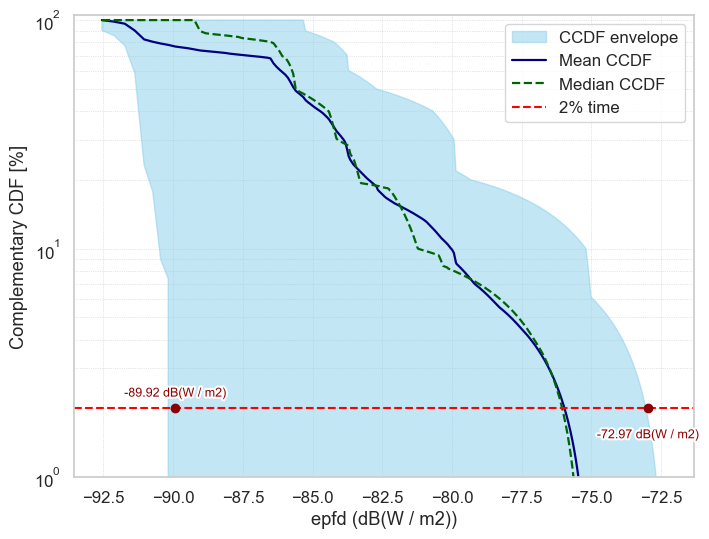

In [21]:
arr=epfd_0_recovered_smoothed.to(cnv.dB_W_m2)


flat = arr.reshape(arr.shape[0], -1, 1)
print(flat.shape)
fig=plot_cdf_ccdf_bounds(flat, show_two_percent=True, show_five_percent=False,y_min_percent=1, plot_type='ccdf')

(10, 7002, 1)


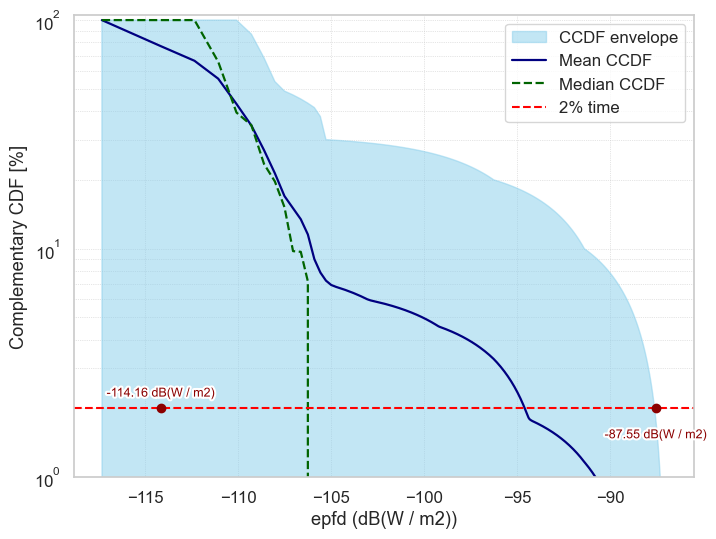

In [22]:
arr=epfd_0_BA_recovered_smoothed.to(cnv.dB_W_m2)


flat = arr.reshape(arr.shape[0], -1, 1)
print(flat.shape)
fig=plot_cdf_ccdf_bounds(flat, show_two_percent=True, show_five_percent=False,y_min_percent=1)